# TP4 : Reconnaissance de mots isolés par programmation dynamique (DTW)

NOM - PRÉNOM : MARZAT Noé
Déposer le notebook sur moodle à la fin de la séance.

In [13]:
import numpy as np
from math import floor, inf, dist
import scipy.io.wavfile as wav
import os
import matplotlib.pyplot as plt

import glob
import pandas as pd
import seaborn as sns

# Réutilisation de fonctions pour la lecture et la paramétrisation

In [14]:
# Réutiliser la fonction lecture permettant de lire un fichier son et de connaître ses caractéristiques 
# (fréquence d’échantillonnage, durée).

# LECTURE d'un fichier Wave
def lecture(fichier, nb_bits=16):
    Fe, Signal = wav.read(fichier)
    duree = Signal.shape[0]/Fe
    Signal_normalise = Signal/((2**(nb_bits-1))-1)
    return (Signal_normalise, Fe, duree)

In [15]:
# Réutiliser la fonction parametrisation qui calcule les paramètres acoustiques
# (coefficients cepstraux) d’un fichier sonore sur des fenêtres de taille  "taille_fenetre"   avec un
# recouvrement de moitié .
    
# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre = 1024, nbe_coef = 16):
    # Initialisation de la matrice résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))

    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc

In [16]:
# Modifier votre fonction parametrisation_total (utilisant la fonction   parametrisation  )
# afin qu’elle permette de calculer les paramètres pour l’ensemble des fichiers d’un répertoire
# rep_wav et de stocker les résultats dans un répertoirenrep_mfcc. Cette fonction renvoie
# la liste des noms de fichiers traités.
"""
def treat_all_file_in_dir(list_of_path, result_dir_name, taille_fenetre, nbe_coef):
    for file in list_of_path:
        signal_obs, _, _ = lecture(file)
        mfcc = parametrisation(signal_obs, taille_fenetre, nbe_coef)
        np.savetxt(result_dir_name + os.path.splitext(os.path.basename(file))[0] + ".mfcc", mfcc)
    
# Fonction de paramétrisation totale --> tous les fichiers du répertoire 'WAV/APP'
def parametrisation_total(taille_fenetre, nbe_coef):
    treat_all_file_in_dir(glob.glob(os.path.join('SIGNAL/REF/', '*.wav')), "MFCC_REF/", taille_fenetre, nbe_coef)
    treat_all_file_in_dir(glob.glob(os.path.join('SIGNAL/OBS/', '*.wav')), "MFCC_OBS/", taille_fenetre, nbe_coef)
    
    return glob.glob(os.path.join('SIGNAL/OBS/', '*.wav')) + glob.glob(os.path.join('SIGNAL/REF/', '*.wav'))
"""

def parametrisation_total(rep_wav, rep_mfcc, nb_bits = 16, taille_fenetre = 1024, nbe_coef = 16):
    if not os.path.exists(rep_mfcc):
        os.makedirs(rep_mfcc)    
    
    for filename in os.listdir(rep_wav):
        if filename.endswith(".wav"):
            signal, _, _ = lecture(os.path.join(rep_wav, filename), nb_bits)
            mfcc = parametrisation(signal, taille_fenetre, nbe_coef)
            np.savetxt(os.path.join(rep_mfcc, filename[:-4] + '.mfcc'), mfcc, fmt='%d') 

# Programmation dynamique

In [17]:
# Ecrire une fonction dtw qui prend deux arguments en entrée : la matrice de coefficients
# cepstraux du signal à reconnaître (observation) et la matrice de coefficients cepstraux d'un
# signal de référence. Cette fonction renvoie le coût normalisé.
""" 
# Calcul de la DTW entre deux vecteurs
def dtw(path_wav_obs, path_mfcc_ref):

    #Loading data
    mfcc_ref = np.loadtxt(path_mfcc_ref)
    len_ref = len(mfcc_ref)
    mfcc_obs = parametrisation(lecture(path_wav_obs))
    len_obs = len(mfcc_obs)

    #Generating dtw matrix
    dtw_matrix = np.zeros((len(mfcc_obs),len(mfcc_ref)))
        #Init of top and left line to infinity
    print(dtw_matrix.shape)
    
    for i in range(0,len_obs-1):
        dtw_matrix[i,0] = np.inf

    for i in range(0,len_ref-1):
        dtw_matrix[0,i] = np.inf
    
    for i in range(1, len_obs):
        for j in range(1, len_ref):
            dtw_matrix[i,j] = np.min([dtw_matrix[i-1, j-1], dtw_matrix[i-1, j], dtw_matrix[i, j-1]]) + dist(mfcc_obs[i], mfcc_ref[j])

    return dtw_matrix[len_obs-1, len_ref-1]/(len_obs-1 * len_ref-1)
"""

def dtw(mfcc_ref, mfcc_obs, coeff_lin = 1, coeff_diag= 2):
    mfcc_ref = np.loadtxt(mfcc_ref)
    mfcc_obs = np.loadtxt(mfcc_obs)
    n, _ = mfcc_ref.shape
    m, _ = mfcc_obs.shape
    d = np.zeros((n, m))
    d[:,0] = np.inf # première ligne à zéro
    d[0,:] = np.inf # première colonne à zéro
    d[0, 0] = 0 # La toute première case est à zéro

    for i in range(1, n):
        for j in range(1, m):
            dist = np.linalg.norm(mfcc_ref[i] - mfcc_obs[j]) # distance euclidienne entre les deux vecteurs 
            d[i, j] = dist + np.min([coeff_lin*d[i-1, j], coeff_lin*d[i, j-1], coeff_diag*d[i-1, j-1]]) # le poids vaut la distance euclidienne entre les deux vecteurs et le minimum de "là où on peut venir"
    
    return d[-1, -1]/(m+n) # On récupère le score puisqu'il se trouve dans la dernière case en bas à droite, que l'on divise par le nombre de colonnes et de lignes pour le normaliser

In [18]:
#Ecrire une fonction   dtw_total   (utilisant la fonction   dtw  ) qui calcule la DTW sur toutes
# les observations (fichiers Wave) du répertoire   rep_obs   par rapport   toutes les références
# (fichiers MFCC) du répertoire   rep_ref. Cette fonction renvoie une matrice de coûts de taille
# nb_fichier_obs x nb_fichier_ref.

# DTW sur toutes les observations par rapport à toutes les références
def dtw_total():
    list_path_obs = glob.glob(os.path.join('MFCC_OBS/', '*.mfcc'))
    list_path_ref = glob.glob(os.path.join('MFCC_REF/', '*.mfcc'))

    #Matrix to store the distances
    result = np.zeros((len(list_path_obs), len(list_path_ref)))

    #Computation on all files
    for i in range(len(list_path_obs)):
        for j in range(len(list_path_ref)):
            result[i,j] = dtw(list_path_obs[i], list_path_ref[j])
    
    return result

# Affichages et tests

In [19]:
# Ecrire un programme principal qui lance les fonctions précédentes et affiche pour chaque
# observation (mot inconnu), le mot le plus probable.

# Initialisation
q = 16
taille_fenetre = 1024
nbe_coef = 16
rep_ref = 'SIGNAL/REF/'
rep_obs = 'SIGNAL/OBS/'
rep_mfcc = 'MFCC'


In [393]:
parametrisation_total('SIGNAL/OBS', 'MFCC_REF', q, taille_fenetre, nbe_coef)

In [20]:
# Paramétrisation des fichiers références
parametrisation_total('SIGNAL/REF', 'MFCC_REF', q, taille_fenetre, nbe_coef)
parametrisation_total('SIGNAL/OBS', 'MFCC_OBS', q, taille_fenetre, nbe_coef)

# Test de la DTW
cost = dtw('MFCC_REF/alpha.mfcc', 'MFCC_OBS/alpha.mfcc')
print(cost)

305.0847293350675


In [21]:
# DTW sur toutes les observations par rapport à chaque référence
cost_matrix = dtw_total()

# Affichage des couts
print(cost_matrix)

[[278.80070094 581.19339304 471.6655361  407.59350514 426.71939091
  380.24318401 396.13289528 432.91932721 365.51348204 383.47475129
  418.13356636 364.40616384 405.44502999]
 [438.18253228 485.08805803 479.10024929 499.02984021 511.19422723
  443.01251846 476.51047627 398.71619989 448.56779252 464.97076289
  420.84263122 438.99382243 434.33211154]
 [536.27092087 699.18965668 442.67572729 507.6656836  565.96204413
  547.7785549  556.78569495 504.53761193 525.06463116 529.24704196
  478.7345552  479.31413684 559.19875697]
 [349.16299331 557.20162602 381.3000497  299.52433376 350.34759457
  379.9013486  359.79350472 396.79275592 380.71149085 415.67921106
  345.12666653 344.43264665 406.20683818]
 [371.96794151 600.70730293 470.12927166 403.42813675 304.1635809
  442.7904969  446.19993359 468.74924469 403.45909962 408.09425142
  424.19278119 430.38867232 408.16715439]
 [380.71793191 585.13790658 478.53143073 426.30168432 483.92340867
  302.23212144 445.21147746 415.07810664 449.42551226 

               Alpha       Bravo     Charlie       Delta        Echo  \
Alpha     278.800701  581.193393  471.665536  407.593505  426.719391   
Bravo     438.182532  485.088058  479.100249  499.029840  511.194227   
Charlie   536.270921  699.189657  442.675727  507.665684  565.962044   
Delta     349.162993  557.201626  381.300050  299.524334  350.347595   
Echo      371.967942  600.707303  470.129272  403.428137  304.163581   
Foxtrott  380.717932  585.137907  478.531431  426.301684  483.923409   
Golf      359.027353  541.667874  451.167429  398.580755  485.538949   
Hotel     392.332736  571.223757  474.154674  454.869733  485.537902   
India     304.089820  573.710183  428.119866  383.508913  405.671846   
Juliett   436.309002  675.109382  518.317419  512.116807  527.376970   
Kilo      388.704115  571.077692  406.748513  439.887022  451.371756   
Lima      338.590826  566.756636  458.880157  427.996495  430.003648   
Mike      409.810787  560.677271  484.135157  424.839653  427.29

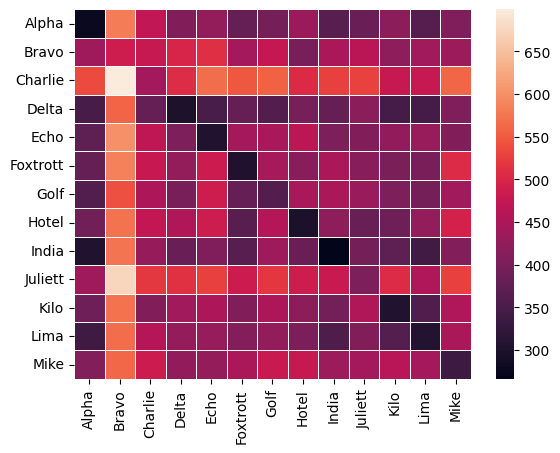

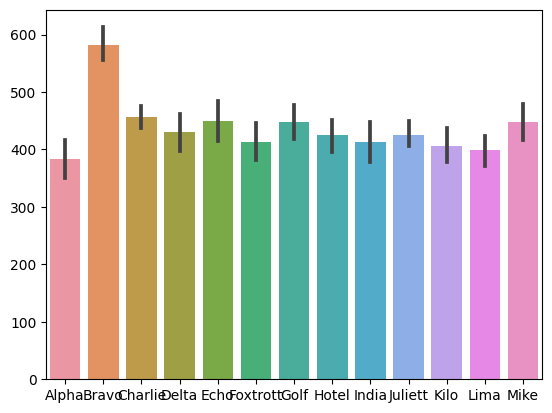

In [82]:
# Affichage amélioré

#On utilise les dataframe de Pandas pour la representation des données
labels = ['Alpha','Bravo','Charlie', 'Delta', 'Echo', 'Foxtrott', 'Golf', 'Hotel', 'India', 'Juliett', 'Kilo', 'Lima', 'Mike']
df = pd.DataFrame(cost_matrix, index=labels, columns=labels)
print(df)

#Heatmap de la matrice de coût (abscisses = references, ordonées = observations)
sns.heatmap(df, fmt="0.1f", linewidths=.5)
plt.figure()

#Barplot
ax = sns.barplot(df)
plt.show()

# Ajouter à votre programme principal, un affichage des coûts entre une observation et chaque
# référence sous forme d'histogramme via la commande bar.
# Calculer le score de reconnaissance.

# Pour chaque observation, affichage des coûts (par rapport aux références) sous forme d'histogramme



In [23]:
# Affichage score final


In [24]:
# Autres tests 
# Tests
# Bien  videmment, afin d’am liorer les r sultats, vous pourrez modifier :
# - le nombre de param tres (coefficients cepstraux) : nbe_coef,
# - la taille de la fen tre d’analyse : taille_fenetre,
# ET TESTER AVEC VOS PROPRES ENREGISTREMENTS !